# Library

In [3]:
import os
import joblib
import my_utils
import gzip
import shutil
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

# Get data

In [2]:
input_gz_file = '../Output/GSE185948_count_RNA.rds.gz'
output_rds_file = '../Output/data_for_r.rds'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_rds_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_rds_file}.')

../Output/GSE185948_count_RNA.rds.gz has been successfully uncompressed to ../Output/data_for_r.rds.


In [3]:
input_gz_file = '../Output/GSE185948_metadata_RNA.csv.gz'
output_csv_file = '../Output/uncompressed_metadata.csv'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_csv_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_csv_file}.')

../Output/GSE185948_metadata_RNA.csv.gz has been successfully uncompressed to ../Output/uncompressed_metadata.csv.


In [4]:
output_path = '../Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [2]:
metadata = pd.read_csv('../Output/uncompressed_metadata.csv')

R code below

In [6]:
pip install --upgrade --no-deps memory_profiler

Note: you may need to restart the kernel to use updated packages.


# Task 1

## Untransposed Data Preparation

In [7]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix, column_names, row_names, row_indices= my_utils.load_data(data_path, row_info_path, column_info_path)

Returning sparse_matrix, column_names, row_names, and row_indices


In [8]:
split_pipeline = Pipeline([
    ('splitter', my_utils.SparseTrainTestSplit(test_size=0.2, random_state=42, row_indices = row_indices)),
    # Add other steps in the pipeline as needed
])

# Fit and transform the pipeline
sparse_train, sparse_test, train_indices, test_indices = split_pipeline.fit_transform(sparse_matrix)
joblib.dump(split_pipeline, 'split_pipeline.pkl')

In [9]:
clean_and_pca_pipeline = Pipeline([
    ('cleaner', my_utils.DataClean()),  # CleanData is performed first
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])

# Fit the pipeline to training
clean_and_pca_pipeline.fit(sparse_train)
joblib.dump(clean_and_pca_pipeline, 'clean_and_pca_pipeline.pkl')

# Transform the training data
pca_sparse_train = clean_and_pca_pipeline.transform(sparse_train)
pca_sparse_test = clean_and_pca_pipeline.transform(sparse_test)

In [10]:
reindexer = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names, output_folder="../Output")
train_pca_df = reindexer.transform(pca_sparse_train, train_indices, "train")
test_pca_df = reindexer.transform(pca_sparse_test, test_indices, "test")

Box Plot and Scatterplot of Data Set with Outliers


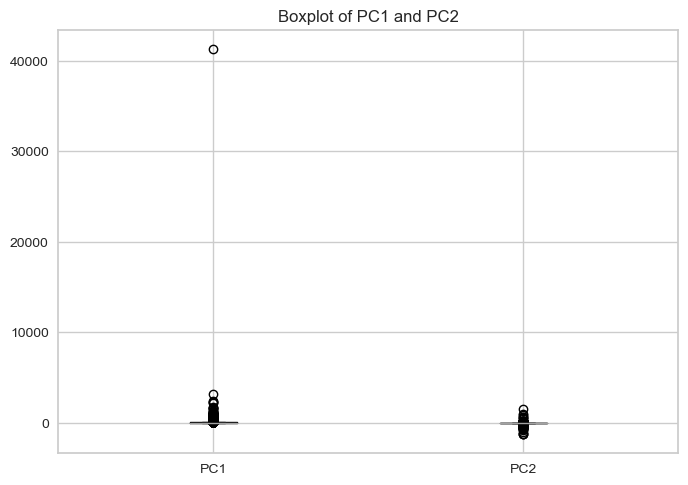

DataFrame of Z-scores sent to output folder
Z-threshold: 10
Df of Outliers sent to output folder
Removing 39 from our dataframe as they exceed our threshold of abs10
Sending updated Df to Output
Box Plot and Scatterplot of Data Set without Outliers


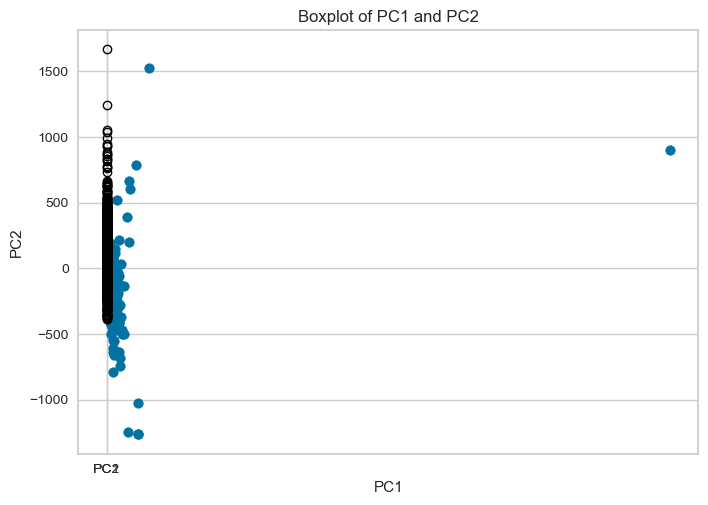

Returning updated dataframe, metadata of rows we removed, and PC of rows we removed


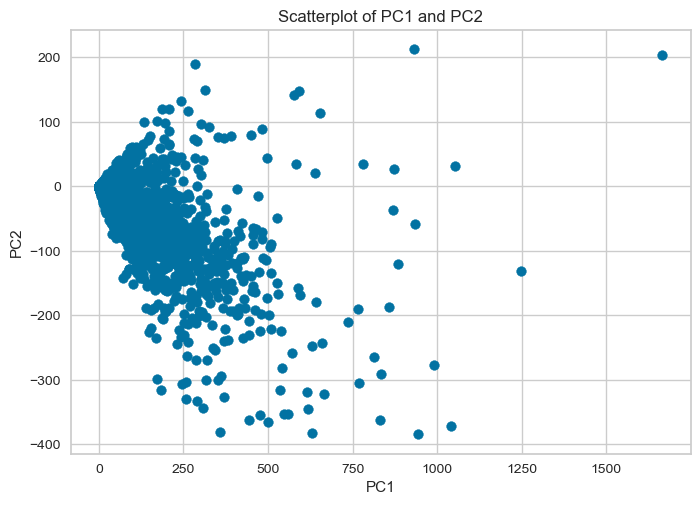

In [11]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"], trans=False, graphs=True)
pca_train_df, metadata_empty, outlier_df = eda_pca.fit_transform(train_pca_df)

## Clustering analysis

In [3]:
pca_train_df = pd.read_csv('../Output/pca_train_df_without_outliers.csv', index_col = 0)
pca_test_df =  pd.read_csv('../Output/pca_test_df.csv', index_col=0)

### HDBSCAN

In [ ]:
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}
# Create a pipeline
# https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970
hdbscan_pipe = Pipeline([
    ("clusterer", my_utils.Optimize_and_Compare_Hdbscan(hdbscan_params)),
])
results_hdb, best_estimator_hdb = \
    my_utils.calculate_silhouette(
        pca_train_df, 
        pca_test_df, 
        hdbscan_pipe
)

joblib.dump(hdbscan_pipe, 'hdbscan_pipe.pkl')

Fitting pipe to the training data


### KMeans

In [ ]:
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}

# Create a pipeline
k_means_pipe = Pipeline([
    ("clusterer", my_utils.OptimizeAndCompareKMeans(kmeans_params)),
])

results_kmeans, best_estimator_kmeans, silhouette_train_kmeans, silhouette_test_kmeans = \
    my_utils.calculate_silhouette(
        pca_train_df, 
        pca_test_df, 
        k_means_pipe, 
        kmeans=True
)

joblib.dump(k_means_pipe, 'k_means_pipe.pkl')

I will use the Kmeans as my best estimator.

In [8]:
best_estimator =  best_estimator_kmeans

In [9]:
scoring_df_untransposed = my_utils.create_labels_and_scoring_df(
    best_estimator, 
    '../Output/best_estimator_untransposed_data_label_and_score', 
    pca_train_df, 
    pca_test_df
)

Sending Result file to ../Output/best_estimator_untransposed_data_label_and_score


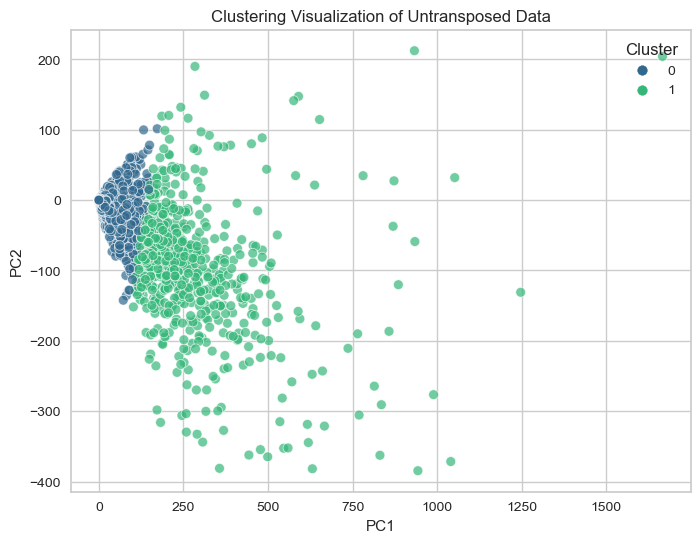

<Figure size 800x550 with 0 Axes>

In [10]:
base_estimator_for_clustering = best_estimator
# Use your best_estimator to predict labels for the data
cluster_labels = base_estimator_for_clustering.fit_predict(pca_train_df)

# Add the cluster_labels to the training data DataFrame
pca_train_df['Cluster'] = cluster_labels

# Create a scatter plot to visualize the clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_train_df, hue='Cluster', palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization of Untransposed Data')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()
plt.savefig(f'../Output/Clustering_on_untransposed_data.pdf')

# Task 2

## Transposed Data Preparation

In [14]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix_trans, row_names_trans, col_names_trans, row_indices_trans= my_utils.load_data(data_path, row_info_path, column_info_path, transpose = True)

Returning Transposed matrix, row_names of the transposed matrix, col_names of the transposed matrix, and row_indices of transposed matrix


## Demographic Feature Cleaning for Training Data

In [15]:
cell_count = metadata['patient'].value_counts(normalize=True)
cell_count.columns = ['patient', 'percentage']
cell_count

PKD2        0.106241
PKD6        0.104167
control4    0.099338
control2    0.093009
PKD1        0.090575
PKD3        0.088687
PKD4        0.088112
PKD5        0.077879
control5    0.075679
control3    0.065193
control1    0.062428
PKD7        0.024428
PKD8        0.024262
Name: patient, dtype: float64

In [16]:
split_pipeline_trans = Pipeline([
    ('splitter', my_utils.PreserveRowIndicesSplitter(
        test_size=0.2, random_state=42,
        input_metadata=metadata, row_names=row_names_trans, groupby_columns=['gender', 'disease']
    )),
    # Add other steps in the pipeline as needed
])
(
    sparse_matrix_train_trans,
    sparse_matrix_test_trans,
    train_row_indices_trans,
    test_row_indices_trans
) = split_pipeline_trans.fit_transform(sparse_matrix_trans)

joblib.dump(split_pipeline_trans, 'split_pipeline_trans.pkl')

Subsetting metadata
Sending balanced sample to /Output/even_distribution_sample.csv


/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:506: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sampled_rows)
/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:506: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sampled_rows)
/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:506: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sample

Subsetting training data to be balanced data set


In [17]:
clean_and_pca_pipeline_trans = Pipeline([
    ('cleaner', my_utils.DataClean(trans=True)),  # Specify that the data is transposed
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])
# Fit the pipeline to training
clean_and_pca_pipeline_trans.fit(sparse_matrix_train_trans)
joblib.dump(clean_and_pca_pipeline_trans, 'clean_and_pca_pipeline_trans.pkl')
# Transform the training data
pca_sparse_train_trans = clean_and_pca_pipeline_trans.transform(sparse_matrix_train_trans)
pca_sparse_test_trans= clean_and_pca_pipeline_trans.transform(sparse_matrix_test_trans)

In [18]:
reindexer_trans = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names_trans, output_folder="../Output", trans = True)
train_pca_df_trans = reindexer_trans.transform(pca_sparse_train_trans,  train_row_indices_trans, "train")
test_pca_df_trans = reindexer_trans.transform(pca_sparse_test_trans, test_row_indices_trans, "test")

Box Plot and Scatterplot of Data Set with Outliers


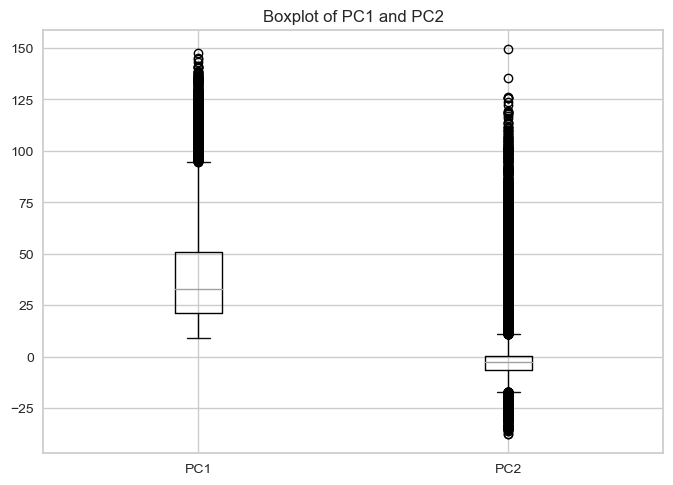

DataFrame of Z-scores sent to output folder
Z-threshold: 10
Df of Outliers sent to output folder
Removing 1 from our dataframe as they exceed our threshold of abs10
Sending updated Df to Output
Box Plot and Scatterplot of Data Set without Outliers


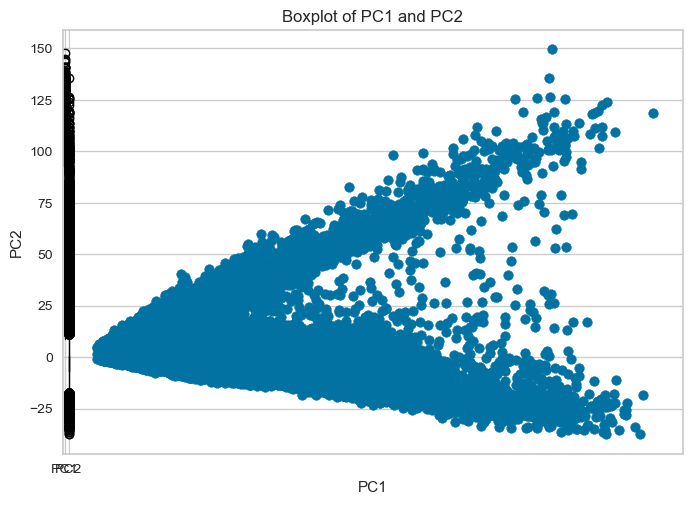

Returning updated dataframe, metadata of rows we removed, and PC of rows we removed


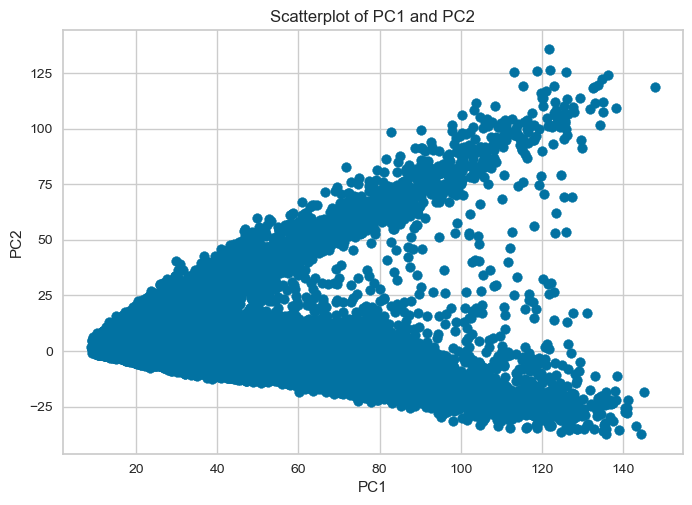

In [19]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"], trans = True, graphs = True)
updated_train_pca_df_trans, metadata_removed, outlier_df_trans= eda_pca.fit_transform(train_pca_df_trans,another_df=  metadata)

## Clustering on the Transposed Data

In [3]:
pca_train_df_trans = pd.read_csv('../Output/pca_train_df_without_outliers_trans.csv', index_col = 0)
pca_test_df_trans =  pd.read_csv('../Output/pca_test_df_trans.csv', index_col=0)

In [4]:
# Define the parameter grid for HDBSCAN
hdbscan_params_trans = {
    'min_samples': [10, 30, 50],
    'min_cluster_size': [100, 200, 300],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['manhattan']
}

# Usage example with parameters
hdbscan_pipe_trans = Pipeline([
    ("clusterer", my_utils.Optimize_and_Compare_Hdbscan(hdbscan_params_trans)),
])
results_hdb_trans, best_estimator_hdb_trans = my_utils.calculate_silhouette(
    pca_train_df_trans, 
pca_test_df_trans, hdbscan_pipe_trans)

joblib.dump(hdbscan_pipe_trans, 'hdbscan_pipe_trans.pkl')

Fitting pipe to the training data
Grid Search Estimator Silhouette Score: -0.19964842826997536
Default HDBSCAN Silhouette Score: 0.6633921732517878
Default Parameter has a higher Silhouette Score.
Using Default Parameter as it performs better based on Silhouette Score.
Saving best estimator
Validation Silhouette Score on Test: -0.4298768624248119
Validation Silhouette Score on Train: 0.6633921732517878
Time taken: 11.63 minutes
Returning fitted pipe and best estimator


In [7]:
kmeans_params_trans = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}

# Create a pipeline
k_means_pipe_trans = Pipeline([
    ("clusterer", my_utils.OptimizeAndCompareKMeans(kmeans_params_trans)),
])

joblib.dump(k_means_pipe_trans, 'k_means_pipe_trans.pkl')

results_kmeans_trans, \
best_estimator_kmeans_trans, \
silhouette_train_kmeans_trans, \
silhouette_test_kmeans_trans = my_utils.calculate_silhouette(
    pca_train_df_trans, 
    pca_test_df_trans, 
    k_means_pipe_trans,
    kmeans=True
)


Fitting pipe to the training data
Grid Search Estimator Silhouette Score: 0.5340370345657811
Default KMeans Silhouette Score: 0.5340370345657811
Default Parameter has a higher Silhouette Score.
Using Default Parameter as it performs better based on Silhouette Score.
Saving best estimator
Validation Silhouette Score on training data: 0.5340370345657811
Validation Silhouette Score on test data: 0.5473329569750532
Time taken: 15.54 minutes
Returning fitted pipe, best estimator, silohoutte score on training and testing


In [8]:
best_estimator_trans = best_estimator_kmeans_trans

In [9]:
scoring_df_transposed= my_utils.create_labels_and_scoring_df(
    best_estimator_trans, 
    '../Output/best_estimator_data_label_and_score_trans', 
    pca_train_df_trans, 
    pca_test_df_trans
)

Sending Result file to ../Output/best_estimator_untransposed_data_label_and_score_trans


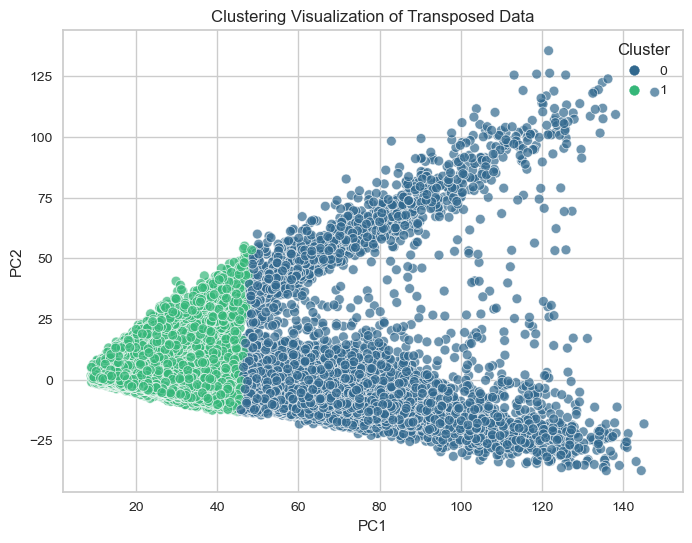

<Figure size 800x550 with 0 Axes>

In [14]:

best_estimator_trans_for_clustering = best_estimator_trans

# Use your best_estimator to predict labels for the data
cluster_labels_trans = best_estimator_trans_for_clustering.fit_predict(pca_train_df_trans)

# Add the cluster_labels to the training data DataFrame
pca_train_df_trans['Cluster'] = cluster_labels_trans

# Create a scatter plot to visualize the clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_train_df_trans, hue='Cluster', palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization of Transposed Data')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()
plt.savefig(f'../Output/Clustering_on_transposed_data.pdf')

## Cluster Profiling

In [5]:
# set working directory for Anh
cwd = 'c:\\Users\\nphda\\OneDrive\\Desktop\\Data Mining\\Jackson-and-Anh-Data-Mining-Assingment-4'

# read cluster data
cluster_data_path = os.path.join(cwd, 'output\\best_estimator_data_label_and_score_trans.csv')
cluster = pd.read_csv(cluster_data_path, index_col=0)

# read metadata
metadata_path = os.path.join(cwd, 'data\\GSE185948_metadata_RNA.csv')
metadata = pd.read_csv(metadata_path)

# merge cluster and metadata
meta_df = pd.merge(cluster, metadata, left_on='Index', right_on='name', how='left').drop('name', axis=1)

# restrict to cluster, gender and disease
meta_df_demo = meta_df[['Cluster_Label', 'gender', 'disease']]

In [6]:
pd.crosstab(meta_df_demo['disease'],meta_df_demo['gender'])

gender,female,male
disease,,
PKD,19044,16621
control,14469,16711


In [7]:
pd.crosstab([meta_df_demo['disease'],meta_df_demo['gender']], meta_df_demo['Cluster_Label'])

Cluster_Label       0      1
disease gender              
PKD     female   2754  16290
        male     4862  11759
control female   2321  12148
        male    10514   6197

In [8]:
# compute Fisher exact count test
m = pd.crosstab(meta_df_demo['disease'], meta_df_demo['Cluster_Label']).to_numpy()
my_utils.fisher_test(m, 'disease')
m = pd.crosstab(meta_df_demo['gender'], meta_df_demo['Cluster_Label']).to_numpy()
my_utils.fisher_test(m, 'gender')

p-value for disease : 0.0
p-value for gender : 0.0


# Task 3

Use BIRCH as the additional cluster algorithm

## Clustering

In [70]:
# get processed data
# set working directory for Anh
cwd = 'c:\\Users\\nphda\\OneDrive\\Desktop\\Data Mining\\Jackson-and-Anh-Data-Mining-Assingment-4'
output_path = 'C:\\Users\\nphda\\OneDrive\\Desktop\\Data Mining\\Jackson-and-Anh-Data-Mining-Assingment-4\\Output'

# read cluster data
pca_test_df_path = os.path.join(cwd, 'Output\\preprocessed\\pca_test_df.csv')
pca_train_df_path = os.path.join(cwd, 'Output\\preprocessed\\pca_train_df.csv')
pca_test_df_trans_path = os.path.join(cwd, 'Output\\preprocessed\\pca_test_df_trans.csv')
pca_train_df_trans_path = os.path.join(cwd, 'Output\\preprocessed\\pca_train_df_trans.csv')

### Original

In [77]:
train_df = pd.read_csv(pca_train_df_path, index_col=0)
test_df = pd.read_csv(pca_test_df_path, index_col=0)
my_utils.birch_cluster(train_df, test_df, 2, os.path.join(output_path, 'birch_cluster.csv'))

Train time taken:  17.7
Train silhouette score:  1.0
Predict time taken:  1.79
Test silhouette score:  0.92


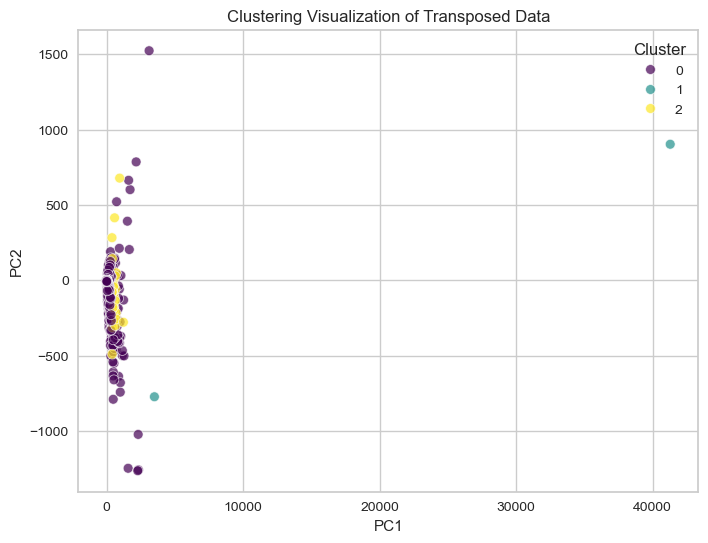

<Figure size 800x550 with 0 Axes>

In [78]:
cluster_birch_path = os.path.join(cwd, 'Output\\birch_cluster.csv')
cluster_birch = pd.read_csv(cluster_birch_path, index_col=0)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=cluster_birch, hue='cluster', palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization of Transposed Data')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()
plt.savefig(os.path.join(output_path, 'images\\Clustering_birch.pdf'))

### Transposed

In [79]:
train_df = pd.read_csv(pca_train_df_trans_path, index_col=0)
test_df = pd.read_csv(pca_test_df_trans_path, index_col=0)

In [80]:
my_utils.birch_cluster(train_df, test_df, 2, os.path.join(output_path, 'birch_cluster_trans.csv'))

Train time taken:  44.88
Train silhouette score:  0.61
Predict time taken:  3.38
Test silhouette score:  0.58


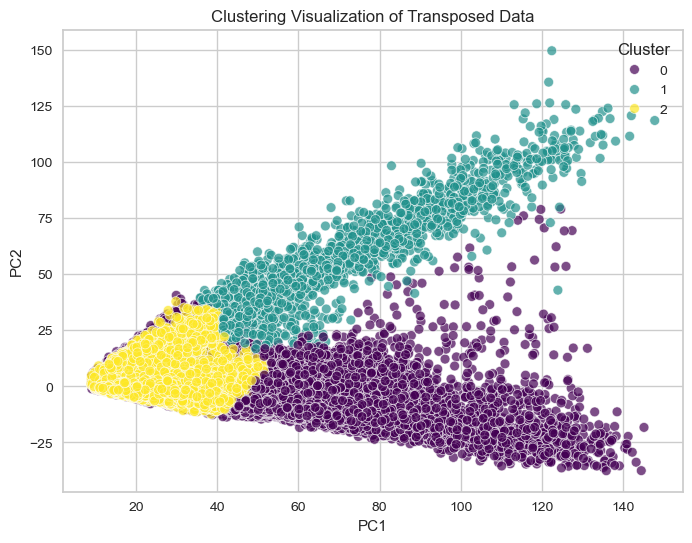

<Figure size 800x550 with 0 Axes>

In [81]:
cluster_birch_trans_path = os.path.join(cwd, 'Output\\birch_cluster_trans.csv')
cluster_birch_trans = pd.read_csv(cluster_birch_trans_path, index_col=0)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=cluster_birch_trans, hue='cluster', palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization of Transposed Data')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()
plt.savefig(os.path.join(output_path, 'images\\Clustering_transposed_birch.pdf'))

## Run time analysis

In [82]:
df = pd.read_csv(pca_train_df_trans_path, index_col=0)
df.shape

(46304, 2)

In [102]:
dataset_sizes = np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4, 7) * 2000, np.arange(4,12) * 4000])

In [104]:
k_means_data, hdbscan_data, birch_data=my_utils.run_time_analysis(df, dataset_sizes)

c:\Users\nphda\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nphda\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nphda\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\nphda\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

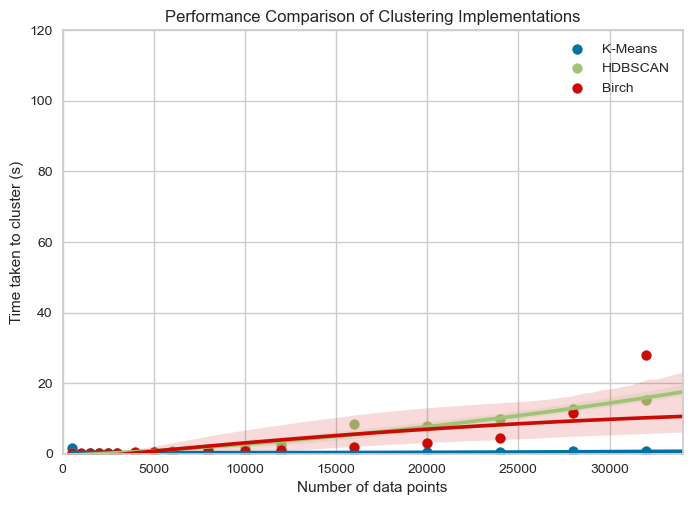

In [107]:
sns.regplot(x='x', y='y', data=k_means_data, order=2,
            label='K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2,
            label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=birch_data, order=2,
            label='Birch', x_estimator=np.mean)

plt.gca().axis([0, 34000, 0, 120])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()
plt.savefig(os.path.join(output_path, 'images\\run_time.pdf'))